## Test basic Synthetic Data

Using the DGMCA code with a realistic dataset and comparing its performance with the original GMCA.

- The data used for the simulation is sent upon request.
- Results are stored in *data_path*
- Input data generated is stored in *input_data_path*
- Plots are saved in *plots_path*

In [2]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as spio
from src.utils2 import divisorGenerator
from src.utils2 import Make_Experiment_GG
from src.misc_bgmca2 import *
from src.DGMCA import DGMCA as dgmca
from src.GMCA import GMCA as gmca
from src.data_input_preparation import data_input_preparation
import copy as cp
from tqdm import tqdm
import time

### Variable definitions

In [3]:
input_data_path = '../files/input_data/'
data_path = '../files/data/'
plots_path = '../files/plots/'

Jdec = 2
dec_factor = 16
batch_size = 2048
n_s = 5 # Number of sources
n_obs = 250 # Number of observations
SNR_level = 60.0
normOpt = 1
alpha_init = 2. # Alpha parameter for the thresholding strategy
numIts = 1

CA_DGMCA = np.zeros([2,numIts])
CA_GMCA = np.zeros([2,numIts])
time_GMCA = np.zeros([numIts])
time_DGMCA = np.zeros([numIts])

### Data preparation 

In [4]:
# If the data has already been generate we just import it
data_save_string = data_path + 'dataGMCA_decf' + str(dec_factor) + '_J_' + str(Jdec) + \
    '_norm_' + str(normOpt) + '_bsize_' + str(batch_size) + '_nobs_' + str(n_obs) + '.mat'
import os.path
if os.path.exists(data_save_string):
    # Import
    data_DGMCA = spio.loadmat(data_save_string)
    # Extract the variables
    X = data_DGMCA['X']
    A0 = data_DGMCA['A0']
    S0 = data_DGMCA['S0']
    X_GMCA = data_DGMCA['X_GMCA']
    S0_GMCA = data_DGMCA['S0_GMCA']
    sizeBlock = data_DGMCA['batch_size'][0,0].astype(int)
    n_s = data_DGMCA['n_s'][0,0]
    WNFactors = data_DGMCA['WNFactors'][0]
    X0_GMCA = data_DGMCA['X0']
    normOpt = data_DGMCA['normOpt']
    line_id = data_DGMCA['line_id'][0]
    r_id = data_DGMCA['r_id']
    totalSize = X.shape[1]     
    
else:
    data_DGMCA = data_input_preparation(Jdec=Jdec, dec_factor=dec_factor, batch_size=batch_size, n_obs=n_obs, \
                SNR_level=SNR_level, normOpt=normOpt, input_data_path=input_data_path, output_data_path=data_path)
    # Extract the variables
    X = data_DGMCA['X']
    A0 = data_DGMCA['A0']
    S0 = data_DGMCA['S0']
    X_GMCA = data_DGMCA['X_GMCA']
    S0_GMCA = data_DGMCA['S0_GMCA']
    sizeBlock = data_DGMCA['batch_size']
    n_s = data_DGMCA['n_s']
    WNFactors = data_DGMCA['WNFactors']
    X0_GMCA = data_DGMCA['X0']
    normOpt = data_DGMCA['normOpt']
    line_id = data_DGMCA['line_id']
    r_id = data_DGMCA['r_id']
    totalSize = X.shape[1] 

In [7]:
#line_id = data_DGMCA['line_id']
#r_id = data_DGMCA['r_id']

print S0.shape
print line_id.shape
print r_id.shape

(5, 16384)
(10,)
(2, 2, 9)


In [8]:
print('*******************************************')
print('totalSize: ' + str(totalSize))
print('numIts: ' + str(numIts))
print('alpha_init: ' + str(alpha_init))
print('n_s: ' + str(n_s))
print('n_obs: ' + str(n_obs))
print('*******************************************')

title_str = "test_basic_synthetic_data" + "_totalSize_" + str(totalSize) + "_batch_size_" + str(batch_size)+ "_n_obs_" + str(n_obs) \
    + "_n_s_" + str(n_s) + '_Jdec_' + str(Jdec) + "_numIts_" + str(numIts)
print("Test saving name:")
print(title_str)
print('*******************************************')


*******************************************
totalSize: 128
numIts: 1
alpha_init: 2.0
n_s: 5
n_obs: 250
*******************************************
Test saving name:
test_basic_synthetic_data_totalSize_128_batch_size_2048_n_obs_250_n_s_5_Jdec_2_numIts_1
*******************************************


### Main loop

In [9]:
for it_n in tqdm(range(numIts)):

    # X,X0,A0,S0,N = Make_Experiment_GG(n_s=n_s,n_obs=n_obs,t_samp=totalSize,noise_level=60.0,\
    #                                   dynamic=0,CondNumber=1,alpha=rho)
    time1 = time.time()
    Results_sB_totSC = gmca(X_GMCA,n=n_s,maxts = 7,mints=3,nmax=100,L0=1,UseP=1,verb=0,Init=0,\
                Aposit=False,BlockSize= None,NoiseStd=[],IndNoise=[],Kmax=1.,AInit=None,tol=1e-6,threshOpt=1\
                ,SCOpt=1)
    time_GMCA[it_n] = time.time() - time1
    A_sB_totSC = Results_sB_totSC['mixmat']
    S_sB_totSC = Results_sB_totSC['sources']
    crit_sB_totSC = EvalCriterion_eval(A0,S0_GMCA,A_sB_totSC,S_sB_totSC) 
    CA_GMCA[0,it_n] = crit_sB_totSC['ca_mean']
    CA_GMCA[1,it_n] = crit_sB_totSC['ca_med']


    time1 = time.time()
    Results_sB0 = dgmca(X,n=n_s,mints=3,nmax=100,L0=1,verb=0,Init=0,BlockSize= None,Kmax=1.,AInit=None,tol=1e-6,\
    		subBlockSize=sizeBlock, SCOpt=1,alphaEstOpt=1,alpha_exp=alpha_init, J=Jdec,WNFactors=WNFactors,normOpt=normOpt)
    time_DGMCA[it_n] = time.time() - time1
    A_sB0 = Results_sB0['mixmat']
    S_sB0 = Results_sB0['sources']
    crit_sB0 = EvalCriterion_eval(A0,S0_GMCA,A_sB0,S_sB0) 
    CA_DGMCA[0,it_n] = crit_sB0['ca_mean']
    CA_DGMCA[1,it_n] = crit_sB0['ca_med']

100%|██████████| 1/1 [03:16<00:00, 196.37s/it]


### Preparing the results

In [10]:
# Some calculations to print afterwards
time_GMCA_mean = np.mean(time_GMCA,axis=0)
time_GMCA_total = np.sum(time_GMCA, axis=0)

time_DGMCA_mean = np.mean(time_DGMCA,axis=0)
time_DGMCA_total = np.sum(time_DGMCA, axis=0)

CA_GMCA_mean = np.mean(CA_GMCA,axis=1)
CA_DGMCA_mean = np.mean(CA_DGMCA,axis=1)
CA_GMCA_med = np.median(CA_GMCA,axis=1)
CA_DGMCA_med = np.median(CA_DGMCA,axis=1)

dB_CA_GMCA_mean = -10*np.log10(CA_GMCA_mean)
dB_CA_DGMCA_mean = -10*np.log10(CA_DGMCA_mean)
dB_CA_GMCA_med = -10*np.log10(CA_GMCA_med)
dB_CA_DGMCA_med = -10*np.log10(CA_DGMCA_med)

### Printing results

In [11]:
# Printing the results nicely
print(' ')
print('******************* Results ************************')
print('GMCA [CA(dB)]            / DGMCA [CA(dB)]')
print('GMCA mean time:  %f  / DGMCA mean time:  %f'%(time_GMCA_mean,time_DGMCA_mean))
print('GMCA total time: %f  / DGMCA total time: %f'%(time_GMCA_total,time_DGMCA_total))
print(' ')
print('**************** MEAN of experiments ***************************')
print('Total size = %d, CA_GMCA(med) = %f,  CA_GMCA(mean) = %f ;'%(totalSize,dB_CA_GMCA_mean[1],dB_CA_GMCA_mean[0]))
print('*******************************************')
print('Batch size = %d, CA_DGMCA(med) = %f,  CA_DGMCA(mean) = %f ;'%(batch_size,dB_CA_DGMCA_mean[1],dB_CA_DGMCA_mean[0]))
print('*******************************************')
print(' ')
print('**************** MEDIAN of experiments ***************************')
print('Total size = %d, CA_GMCA(med) = %f,  CA_GMCA(mean) = %f ;'%(totalSize,dB_CA_GMCA_med[1],dB_CA_GMCA_med[0]))
print('*******************************************')
print('Batch size = %d, CA_DGMCA(med) = %f,  CA_DGMCA(mean) = %f ;'%(batch_size,dB_CA_DGMCA_med[1],dB_CA_DGMCA_med[0]))
print('*******************************************')
print(' ')


 
******************* Results ************************
GMCA [CA(dB)]            / DGMCA [CA(dB)]
GMCA mean time:  19.877356  / DGMCA mean time:  176.488892
GMCA total time: 19.877356  / DGMCA total time: 176.488892
 
**************** MEAN of experiments ***************************
Total size = 128, CA_GMCA(med) = 25.186801,  CA_GMCA(mean) = 21.101015 ;
*******************************************
Batch size = 2048, CA_DGMCA(med) = 25.585799,  CA_DGMCA(mean) = 21.589047 ;
*******************************************
 
**************** MEDIAN of experiments ***************************
Total size = 128, CA_GMCA(med) = 25.186801,  CA_GMCA(mean) = 21.101015 ;
*******************************************
Batch size = 2048, CA_DGMCA(med) = 25.585799,  CA_DGMCA(mean) = 21.589047 ;
*******************************************
 


### Saving variables

In [12]:
# Save variables
title_CA_DGMCA = data_path + 'CA_DGMCA' + title_str  
np.save(title_CA_DGMCA,CA_DGMCA)
title_CA_GMCA = data_path + 'CA_GMCA' + title_str  
np.save(title_CA_GMCA,CA_GMCA)


# Plot results nicely

### Full quality input image 

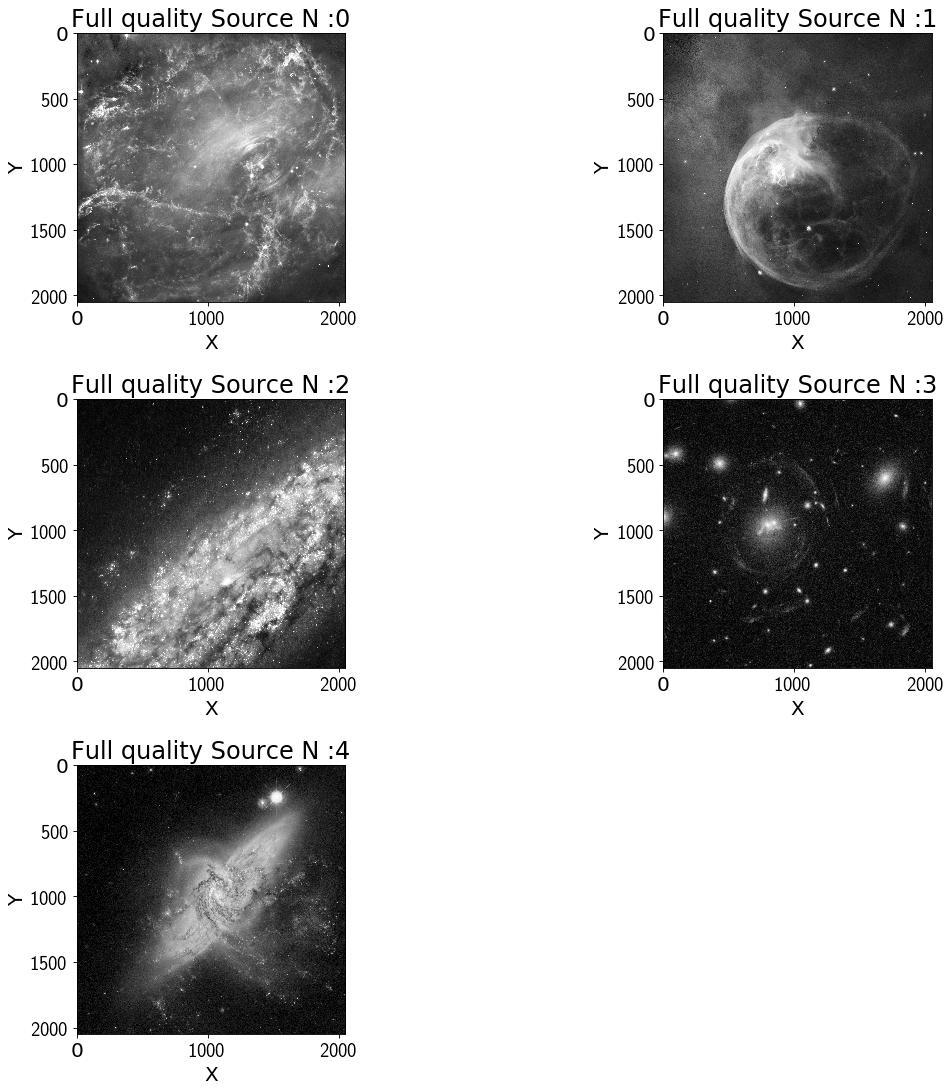

In [13]:
sim_path = input_data_path + 'SyntheticAstroData.mat'
imp_data = spio.loadmat(sim_path)
A_big = imp_data[',mixmat']
S_big = imp_data['sources']

matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(3, 2, figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
plt.rc('text', usetex=True)

for it in range(n_s):

    ax[it/2,it%2].imshow(S_big[it,:,:],cmap='gray')
    ax[it/2,it%2].set_xlabel('X')
    ax[it/2,it%2].set_ylabel('Y')
    ax[it/2,it%2].set_title(r"Full quality Source N :" + str(it))
    
ax[2,1].set_visible(False)

fig.tight_layout()
plt.show()

### Input images

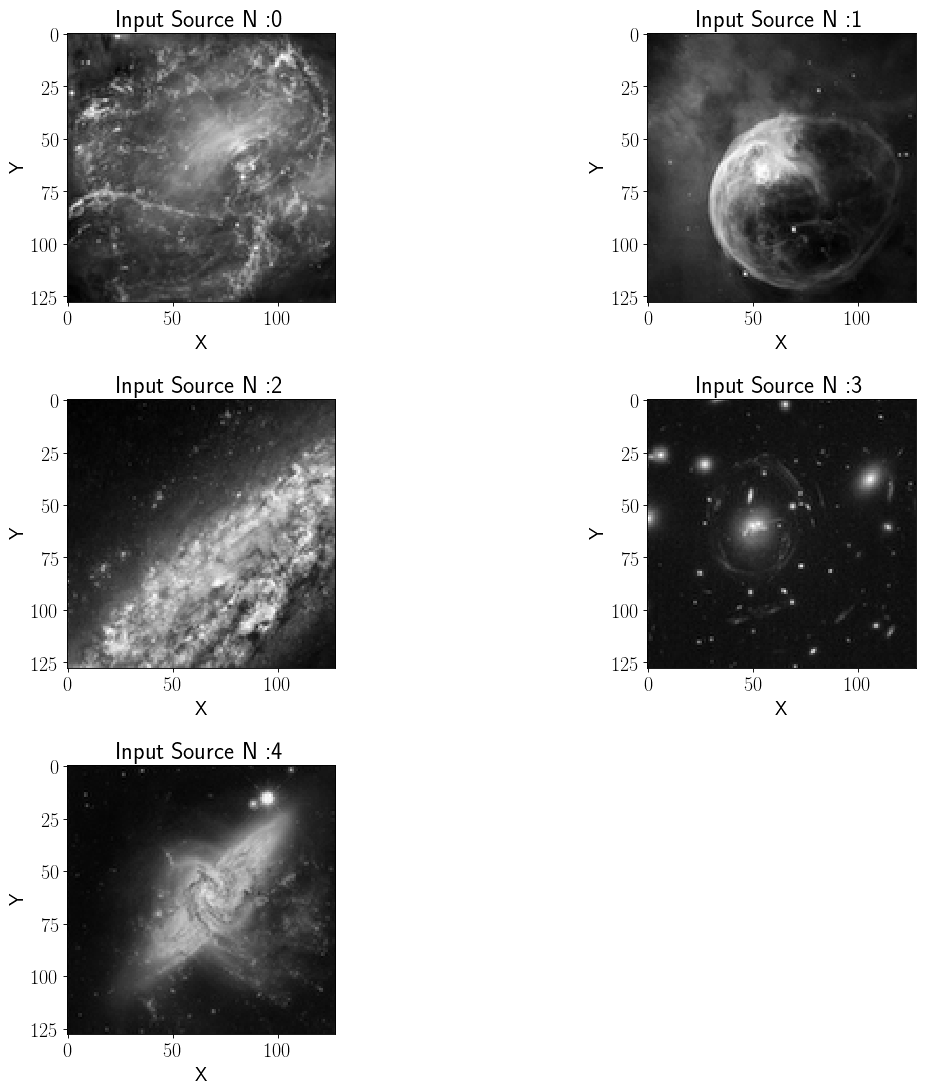

In [14]:
output_imgs = Results_sB0['images']

S0_2D = np.zeros([output_imgs.shape[0],output_imgs.shape[1],S0.shape[0]])

for it in range(S0.shape[0]):
    S0_2D[:,:,it] = recoverDecImg(S0[it,:],r_id,line_id)
    

matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(3, 2, figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
plt.rc('text', usetex=True)

for it in range(n_s):

    ax[it/2,it%2].imshow(S0_2D[:,:,it],cmap='gray')
    ax[it/2,it%2].set_xlabel('X')
    ax[it/2,it%2].set_ylabel('Y')
    ax[it/2,it%2].set_title(r"Input Source N :" + str(it))
    
ax[2,1].set_visible(False)

fig.tight_layout()
plt.show()

### Output images
The reconstruction is done very basicly, just inverting the estimated mixing matrix A and multiplying it with the observation matrix X. This reconstruction is very succestible to noise.

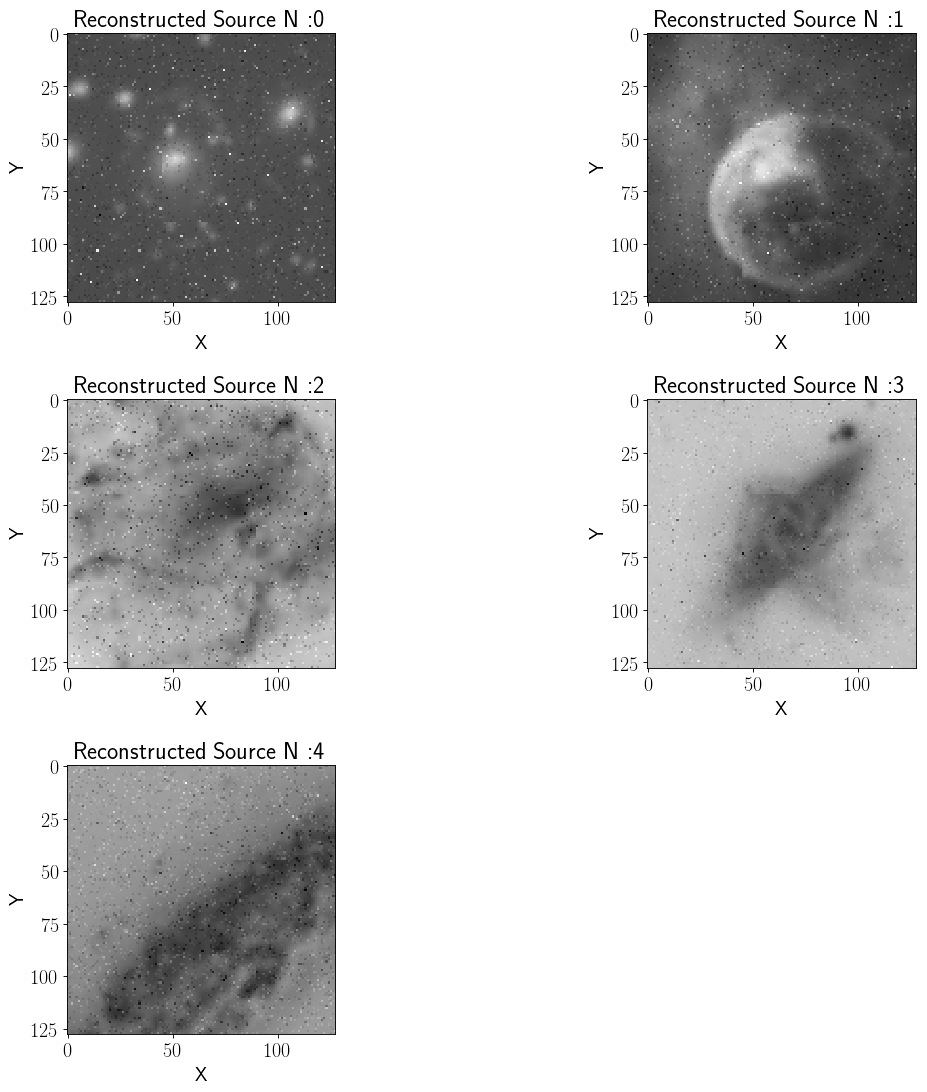

In [15]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(3, 2, figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
plt.rc('text', usetex=True)

for it in range(n_s):

    ax[it/2,it%2].imshow(output_imgs[:,:,it],cmap='gray')
    ax[it/2,it%2].set_xlabel('X')
    ax[it/2,it%2].set_ylabel('Y')
    ax[it/2,it%2].set_title(r"Reconstructed Source N :" + str(it))
    
ax[2,1].set_visible(False)

fig.tight_layout()
plt.show()
